#  Polynomial Regression for Genomic Expression Modeling

**Objective**: Develop a custom polynomial regression model in PyTorch to predict gene expression levels from nucleotide combinations (synthetic data), accurately recovering known biological interactions (e.g., `A²`, `G×C`, `A×T×G`) with `R²=0.99`

**Key Highlights**:
* Simulated gene expression as

  `y = 0.3*A² + 0.1*T - 0.4*G*C + 0.2*A*T*G`

* Model learned coefficients:
  * `0.3000` (`A²`),
  * `-0.4001` (`G×C`),
  * `0.2000` (`A×T×G`)

  (matches ground truth)

* `GenomePolynomialMode()` Dynamically encodes nucleotide interactions (e.g., AA, GC, ATG) based on user needs

* `NucleotideEncoder()` Maps biological terms (e.g., "ATG") to tensor operations

* Near-perfect fit (`R²=0.99`) on test data (May be overfitted)

* Visualized predictions vs. ground truth with matplotlib

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

For the synthetic dataset, we use polynomial terms that mimin non linear gene interactions

> While this dataset works as a controlled simulation, real data may need higher order terms

In [ ]:
# generate the random data sequence
seed = torch.manual_seed(42)

sample = 1000 # number of sample data we are "collecting"
X = torch.randint(0,100,(sample, 4)).float() # the tensor is 1000,4

# gene expression we want to find is
'''
y = (0.3 * X[:, 0]**2 + 0.1 * X[:, 1] -
     0.4 * X[:, 2] * X[:, 3] +
     0.2 * X[:, 0] * X[:, 1] * X[:, 2] +
     5 * torch.randn(sample)).unsqueeze(dim=1)
'''

y = (0.3 * X[:, 0]**2 + 0.1 * X[:, 1] -
     0.4 * X[:, 2] * X[:, 3] +
     0.2 * X[:, 0] * X[:, 1] * X[:, 2]).unsqueeze(dim=1)
# y = 0.3*A² + 0.1*T - 0.4*G*C + 0.2*A*T*G

In [ ]:
# training and testing split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


This model learns polynomial relationships between nucleotide features (A, T, G, C counts) and gene expression levels. It is Designed to capture biologically meaningful interactions (e.g., A², G×C, A×T×G) with interpretable coefficients


Initialization (`__init_`):
  * `degrees`: Maximum polynomial degree (e.g., 2 for quadratic terms like A²)

  * `input_dimension`: Number of input features (4 nucleotides)

  * `specified_terms`: Predefined interactions (e.g., [(0,0), (1,), (2,3)] for A², T, G×C)

  * `self.coefficients`: Learnable weights for each polynomial term (initialized randomly)

Forward Pass (`forward`):
  * For each term in `specified_terms` (e.g., `(0,1,2)` for `A×T×G`):
    * Computes the product of nucleotide counts (`torch.prod(x[:, combo])`)
    
    * Example: `x[:, (2,3)]` -> `G×C` interaction

  * Stacks all terms into a feature matrix (`polynomial_features`)

  * Returns a linear combination
    * `polynomial_features @ coefficients`

Each coefficient corresponds to a biological interaction (e.g., `-0.4` for `G×C`), and it handles arbitrary terms without manual feature engineering. Additionally, it avoids exponential growth of terms by focusing on user-specified interactions

In [ ]:
# the polynomial model
class GenomePolynomialMode(nn.Module):
  def __init__(self, degrees = 2, input_dimension = 4, specified_terms=None):
    super().__init__()
    self.degrees = degrees
    self.input_dimension = input_dimension

    self.combinations = []
    self.combinations = specified_terms

    # create the weights for each combination
    self.coefficients = nn.Parameter(torch.rand(len(self.combinations)), requires_grad=True)

  def forward(self, x):
    features = []

    for combo in self.combinations:
      feature = torch.prod(x[:, combo], dim=1) # multiple each nucleotide
      # for instance x[:0] is a then u a
      # for instance x[:1] is at then u a*t
      # for instance x[:2] is atg then u a*t*g
      features.append(feature.unsqueeze(dim=1))
      # and append each result to feature

    # stack it like a + aa + aaa + t + ... for all the feature in the features list
    polynomial_features = torch.cat(features, dim=1)

    # Linear combination
    return polynomial_features @ self.coefficients.unsqueeze(dim=1)

The nucleotide encoder helps with user interaction where the user just has to input the nucleotide combination they want to check in english.

The function `NucleotideEncoder()` takes this and provides the encoded version without manual feature engineering

In [ ]:
from itertools import combinations_with_replacement

class NucleotideEncoder:
    def __init__(self, max_degree=3):
        self.max_degree = max_degree
        self.nucl_to_id = {'A':0, 'T':1, 'G':2, 'C':3}
        self.id_to_nucl = {v:k for k,v in self.nucl_to_id.items()}

        # Generate all possible combinations
        self.combinations = []
        for degree in range(1, max_degree + 1):
            for combo in combinations_with_replacement(range(4), degree):
                self.combinations.append(combo)

        self.combination_to_tuple = {}
        for combo in self.combinations:
            nuc_str = ''.join(self.id_to_nucl[idx] for idx in combo)
            # Store both original and sorted versions
            self.combination_to_tuple[nuc_str] = combo
            sorted_str = ''.join(sorted(nuc_str))
            if sorted_str != nuc_str:
                self.combination_to_tuple[sorted_str] = combo

    def encode(self, user_input):
        indices = []
        for combo in user_input:
            upper_combo = combo.upper()

            if upper_combo not in self.combination_to_tuple:
                for char in upper_combo:
                    if char not in self.nucl_to_id:
                        raise ValueError(f"Invalid nucleotide '{char}' in combination: {combo}")

                if len(upper_combo) > self.max_degree:
                    raise ValueError(f"Combination '{combo}' exceeds max_degree={self.max_degree}")
                raise ValueError(f"Combination '{combo}' not found in generated combinations")

            indices.append(self.combination_to_tuple[upper_combo])
        return indices

In [ ]:
# specified_terms = [(0,0), (1), (2,3), (0,1,2)] # aa t gc atg
encoder = NucleotideEncoder(max_degree=3)
input_combos = ['aa', 't', 'gc', 'atg']
specified_terms = encoder.encode(input_combos)
genomeModel = GenomePolynomialMode(degrees=3, specified_terms = specified_terms)

For the loss function, we use `Mean Squared Error` `MSELoss()` since it is regression and this loss function is the most efficient.

For the optimiser we use `Adam()` beacuse it has an adaptive learning rate `lr=0.001` for the polynomial term scaling

In [ ]:
# loss function and optimiser
lossFunctionGenome = nn.MSELoss()
optimiserGenome = optim.Adam(genomeModel.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiserGenome, 'min')

For the `Training Loop`, this is the workflow:
1. put the model in training mode with `train()` and perform a `forward pass` to get the predicted values

2. use the `loss` function to get the Mean squared error with the true values and the predicted values

3. ensure there is no accumulation of parameters by setting the optimiser to `zero_grad()` before changing the parameteres based on the loss

4. perform a `back propogation` with the loss function using `backward()`

5. tune the parameters with the optimiser using `step()` using the loss found to make it more efficient

In [ ]:
from math import e
# training loop
epochs = 10000

for epoch in range(epochs):
  # put the model in eval mode
  genomeModel.train()

  # get the predictions
  y_predictions = genomeModel(x_train)

  # calculate the loss
  loss = lossFunctionGenome(y_predictions, y_train)

  # set the optim grad to 0
  optimiserGenome.zero_grad()

  # backward propogation of loss
  loss.backward()

  # optimise the parameters with step
  optimiserGenome.step()

  # scheduler step
  scheduler.step(loss)

In [ ]:
genomeModel.eval()
with torch.no_grad():
  test_prediction = genomeModel(x_test)


In [ ]:

print("\nLearned coefficients for key terms:")
for term in range(0,4):

    print(f"{term}: {genomeModel.coefficients[term].item():.4f}")

print("\noriginal values are: \n (0,0) = 0.3 \n (1,) 0.1 \n (2,3): 0.4 \n 0.2")



Learned coefficients for key terms:
0: 0.3000
1: 0.1124
2: -0.4001
3: 0.2000

original values are: 
 (0,0) = 0.3 
 (1,) 0.1 
 (2,3): 0.4 
 0.2


Visualise the data with a `scatter plot` where the `red` dots are the `true` values, adn the `green` dots are the `predicted` values

You can see that the color in the graph is a combination of red and green showing that the predictions are near accurate

To check this, we use the `R2 score` from `sklearn.metrics` and it is `0.99`

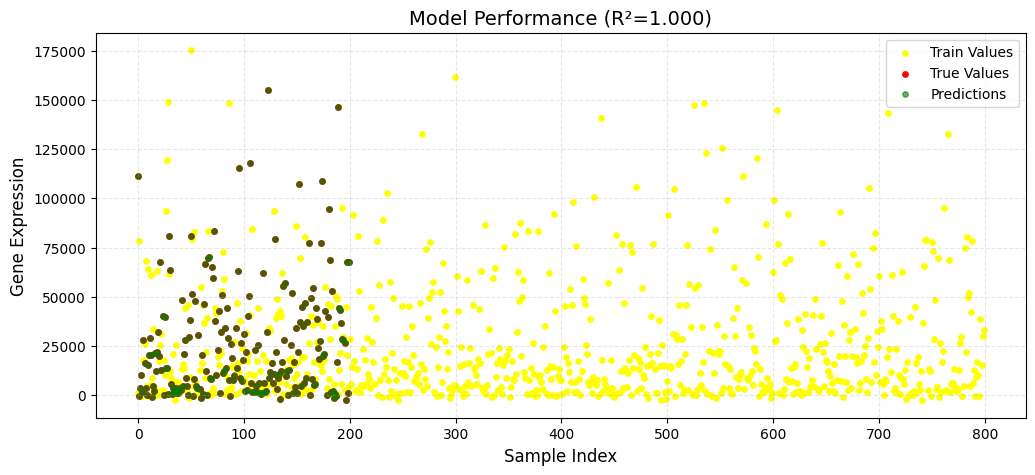

In [ ]:
from sklearn.metrics import r2_score

y_true = y_test.cpu().numpy().flatten()
y_train = y_train
y_pred = test_prediction.cpu().detach().numpy().flatten()

# Plot
plt.figure(figsize=(12, 5))
plt.scatter(range(len(y_train)), y_train, color='yellow', label='Train Values', s=15)
plt.scatter(range(len(y_true)), y_true, color='red', label='True Values', s=15)
plt.scatter(range(len(y_pred)), y_pred, color='green', label='Predictions', s=15, alpha=0.6)
plt.xlabel("Sample Index", fontsize=12)
plt.ylabel("Gene Expression", fontsize=12)
plt.title(f"Model Performance (R²={r2_score(y_true, y_pred):.3f})", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()